In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from matplotlib import cm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import plotting
from src.utils import combine_prediction_files, compute_network_avg_prediction

# Load in the necessary data

## The model results summaries

In [6]:
datadir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes_old'

results_df = pd.read_csv(os.path.join(datadir, 'p_models', 'selected_features', 'all.stat.results.csv'))
results_allfeats_df = pd.read_csv(os.path.join(datadir, 'p_models','all_features', 'all.stat.results.csv'))

In [7]:
results_df.head()

,cv_mean_best,cv_std_best,cv_ind_sel,cv_mean_sel,cv_std_sel,C_best,gamma_best,C_sel,gamma_sel,train_r2,train_rmse,test_r2,test_rmse,holdout_r2,holdout_rmse,station,phase
0,0.915035,0.005912,24,0.912131,0.004841,10.0,0.10,1.0,0.1,0.932,0.147,0.915,0.164,0.884,0.198,YHB,P
1,0.821419,0.018538,24,0.821419,0.018538,1.0,0.10,1.0,0.1,0.859,0.211,0.834,0.220,0.044,0.577,YDC,P
2,0.903960,0.006974,24,0.903960,0.006974,1.0,0.10,1.0,0.1,0.925,0.157,0.914,0.164,0.816,0.239,YWB,P
3,0.904138,0.005449,24,0.904138,0.005449,1.0,0.10,1.0,0.1,0.924,0.153,0.912,0.166,0.835,0.235,MCID,P
4,0.900035,0.013180,24,0.896342,0.011197,100.0,0.01,1.0,0.1,0.922,0.157,0.901,0.171,0.816,0.250,YHL,P


## The example counts

In [8]:
## READ IN DF FOR COUNTS ##
split_cnts = pd.read_csv(os.path.join(datadir, 'feature_splits', 'p.station.ex.counts.csv'))
df_2022 = pd.read_csv(os.path.join(datadir, 'feature_splits', 'p.2022.csv'))
####
# Count 2022 stations, merge with train and test cnts
split_cnts = split_cnts.merge(
    df_2022.groupby('station')['event_identifier'].count().reset_index().rename(
        columns={'event_identifier': 'cnt_holdout'}), on='station', how='left')
# Filter to stations with trained models
split_cnts = split_cnts[split_cnts['station'].isin(results_df.station)]
# Fill Nan values with 0
split_cnts['cnt_holdout'] = split_cnts['cnt_holdout'].fillna(0)
# Change cnt types to int
split_cnts = split_cnts.astype({'cnt_train': int, 'cnt_test':int, 'cnt_holdout':int})
split_cnts.head()

,station,cnt_train,cnt_test,cnt_holdout
0,YNR,4009,1008,17
1,YHH,4005,1002,185
2,YMC,3553,898,181
3,YMR,3393,845,177
4,YPM,3358,843,172


In [9]:
split_cnts['cnt_train'].describe()

count      34.000000
mean     1635.941176
std      1234.868069
min       343.000000
25%       546.750000
50%      1145.500000
75%      2871.000000
max      4009.000000
Name: cnt_train, dtype: float64

## The model predictions

In [10]:
all_stats = results_df['station']
pred_path = os.path.join(datadir,'p_models', 'selected_features')
train_preds_df = combine_prediction_files(all_stats, pred_path,'P', 'train')
test_preds_df = combine_prediction_files(all_stats, pred_path,'P', 'test')
train_preds_df

,Evid,magnitude,predicted_magnitude,station
0,60000622,0.694976,0.750680,YHB
1,60001352,2.250510,2.150472,YHB
2,60001367,2.155231,2.148788,YHB
3,60001392,2.076413,1.522121,YHB
4,60001397,2.273901,2.196029,YHB
...,...,...,...,...
492,60434112,0.910973,0.921659,YDD
493,60456872,3.207673,3.307287,YDD
494,60456897,2.121661,2.353166,YDD
495,60456907,3.098341,3.198398,YDD


In [11]:
holdout_preds_df = combine_prediction_files(df_2022['station'].unique(), pred_path,'P', 'holdout')
holdout_preds_df

,Evid,magnitude,predicted_magnitude,station
0,60475807,2.403296,2.296476,YMS
1,60480922,2.448282,2.399605,YMS
2,60481752,1.389860,1.633909,YMS
3,60483757,2.233690,2.453516,YMS
4,60483842,1.960314,2.175337,YMS
...,...,...,...,...
12,60506742,1.450397,1.573381,YNR
13,60507132,1.052885,1.286814,YNR
14,60505222,0.488491,0.547220,YNR
15,60505332,0.480386,0.810478,YNR


In [12]:
train_preds_df.drop_duplicates('Evid')['magnitude'].describe()

count    5131.000000
mean        1.322708
std         0.553594
min        -0.041446
25%         0.934720
50%         1.266396
75%         1.629579
max         4.326333
Name: magnitude, dtype: float64

In [13]:
holdout_preds_df[holdout_preds_df['magnitude'] > 4]

,Evid,magnitude,predicted_magnitude,station
8,60497322,4.332082,3.702084,YMS
22,60497322,4.332082,2.684687,YLA
32,60497322,4.332082,3.769792,YLT
47,60497322,4.332082,4.276733,YPP
25,60497322,4.332082,2.465208,YTP
43,60497322,4.332082,3.915113,YDD
27,60497322,4.332082,4.024814,FLWY
75,60497322,4.332082,2.443875,YML
94,60497322,4.332082,2.570228,YPM
98,60497322,4.332082,2.740351,YHH


# Look at the scores from various splits

In [14]:
results_df['train_r2'].describe()

count    34.000000
mean      0.911853
std       0.022649
min       0.850000
25%       0.900250
50%       0.917000
75%       0.924750
max       0.947000
Name: train_r2, dtype: float64

In [15]:
results_df['test_r2'].describe()

count    34.000000
mean      0.881441
std       0.037027
min       0.740000
25%       0.863250
50%       0.891500
75%       0.905000
max       0.919000
Name: test_r2, dtype: float64

In [16]:
results_df['holdout_r2'].describe()

count    25.000000
mean      0.759320
std       0.203791
min       0.044000
25%       0.788000
50%       0.835000
75%       0.869000
max       0.905000
Name: holdout_r2, dtype: float64

In [17]:
(test_preds_df['magnitude'] - test_preds_df['predicted_magnitude']).describe()

count    13958.000000
mean         0.000767
std          0.182133
min         -1.029414
25%         -0.112167
50%          0.000179
75%          0.111851
max          1.050242
dtype: float64

In [18]:
# Remove the large event
(test_preds_df[test_preds_df['magnitude'] < 4]['magnitude'] - test_preds_df[test_preds_df['magnitude'] < 4]['predicted_magnitude']).describe()

count    13958.000000
mean         0.000767
std          0.182133
min         -1.029414
25%         -0.112167
50%          0.000179
75%          0.111851
max          1.050242
dtype: float64

In [19]:
(holdout_preds_df['magnitude'] - holdout_preds_df['predicted_magnitude']).describe()

count    2308.000000
mean       -0.017057
std         0.255177
min        -1.495171
25%        -0.163696
50%        -0.036569
75%         0.106041
max         1.916329
dtype: float64

In [20]:
# Remove the large event
(holdout_preds_df[holdout_preds_df['magnitude'] < 4]['magnitude'] - holdout_preds_df[holdout_preds_df['magnitude'] < 4]['predicted_magnitude']).describe()

count    2288.000000
mean       -0.027445
std         0.223415
min        -1.495171
25%        -0.165161
50%        -0.038074
75%         0.101087
max         1.246293
dtype: float64

In [21]:
# Removing YDC
(holdout_preds_df[holdout_preds_df['station'] != "YDC"]['magnitude'] - holdout_preds_df[holdout_preds_df['station'] != "YDC"]['predicted_magnitude']).describe()

count    2241.000000
mean       -0.029465
std         0.237764
min        -1.495171
25%        -0.165787
50%        -0.040671
75%         0.096291
max         1.916329
dtype: float64

In [22]:
# Remove both 4.3 and YDC
(holdout_preds_df[(holdout_preds_df['station'] != "YDC") & 
                  (holdout_preds_df['magnitude'] < 4)]['magnitude'] -
                    holdout_preds_df[(holdout_preds_df['station'] != "YDC") &
                    (holdout_preds_df['magnitude'] < 4)]['predicted_magnitude']).describe()

count    2221.000000
mean       -0.040278
std         0.201300
min        -1.495171
25%        -0.167128
50%        -0.043196
75%         0.093004
max         0.713117
dtype: float64

In [23]:
holdout_large_resids = holdout_preds_df[abs(holdout_preds_df['magnitude'] - holdout_preds_df['predicted_magnitude']) > 0.5]

(0.0, 4.5)

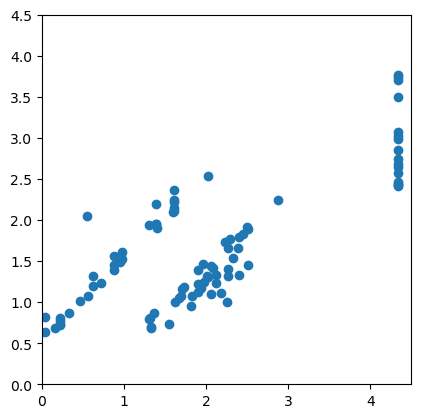

In [24]:
fig, ax = plt.subplots(1)
ax.scatter(holdout_large_resids['magnitude'], holdout_large_resids['predicted_magnitude'])
ax.set_aspect('equal', adjustable='box')
ax.set_xlim([0, 4.5])
ax.set_ylim([0, 4.5])

In [25]:
holdout_large_resids['station'].value_counts()

station
YDC     31
YML      9
YLA      7
YFT      6
YGC      5
YHL      4
YTP      3
YHH      3
YMC      3
YLT      2
YWB      2
YUF      2
YHB      2
YPM      2
MCID     2
FLWY     1
YMS      1
YPP      1
YMR      1
YNM      1
TPMT     1
YPC      1
Name: count, dtype: int64

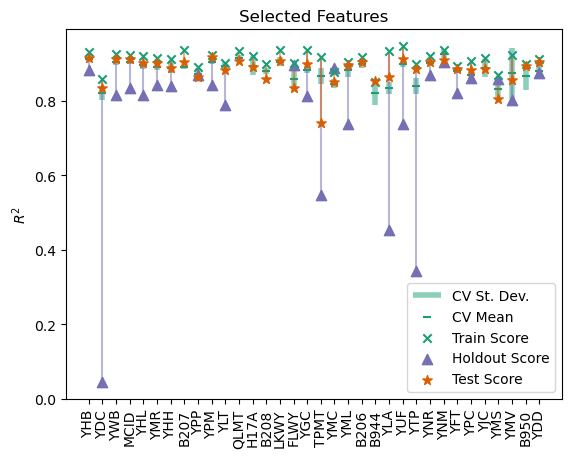

In [26]:
plotting.plot_station_splits_scores_scatter(results_df, title='Selected Features', vlines=True)

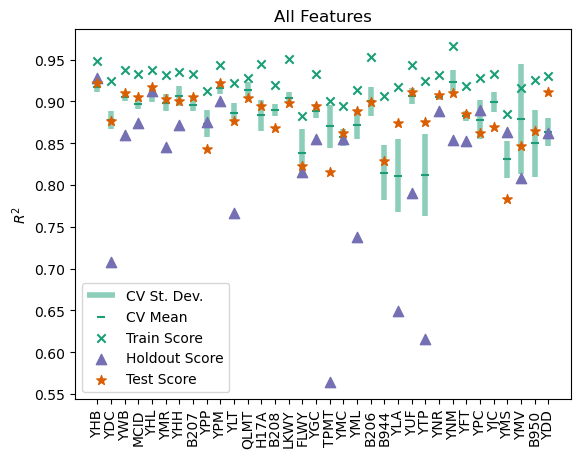

In [27]:
plotting.plot_station_splits_scores_scatter(results_allfeats_df, title='All Features')

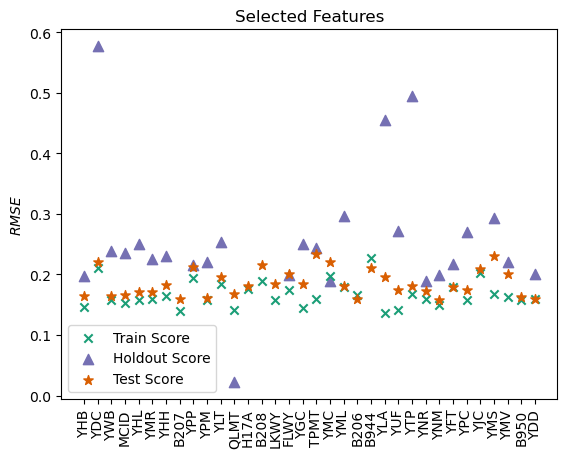

In [28]:
plotting.plot_station_splits_scores_scatter(results_df, 
                            metric='rmse', 
                            ylabel='RMSE',
                            title='Selected Features')

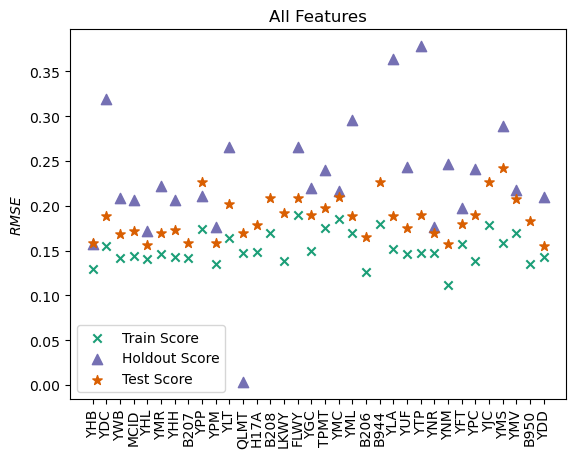

In [29]:
plotting.plot_station_splits_scores_scatter(results_allfeats_df, 
                            metric='rmse', 
                            ylabel='RMSE',
                            title='All Features')

# Compare the scores of a single split using different features

Index(['station', 'train_r2_x', 'train_r2_y'], dtype='object')


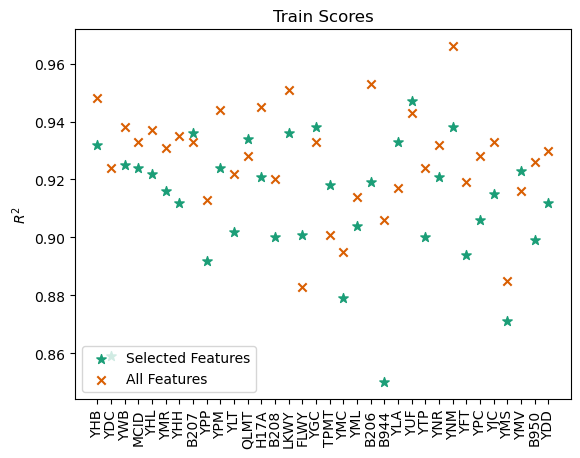

In [30]:
plotting.compare_score_different_feats_scatter(results_df, 
                               results_allfeats_df,
                               'Selected Features',
                               'All Features',
                               col_name='train_r2',
                               title='Train Scores'
                               )

Index(['station', 'test_r2_x', 'test_r2_y'], dtype='object')


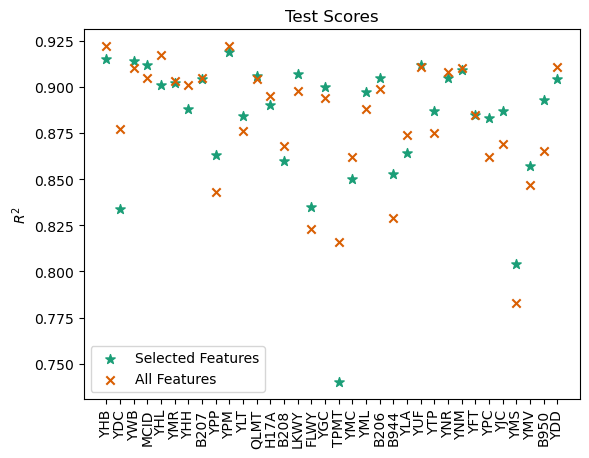

In [31]:
plotting.compare_score_different_feats_scatter(results_df, 
                               results_allfeats_df,
                               'Selected Features',
                               'All Features',
                               title='Test Scores'
                               )

Index(['station', 'holdout_r2_x', 'holdout_r2_y'], dtype='object')


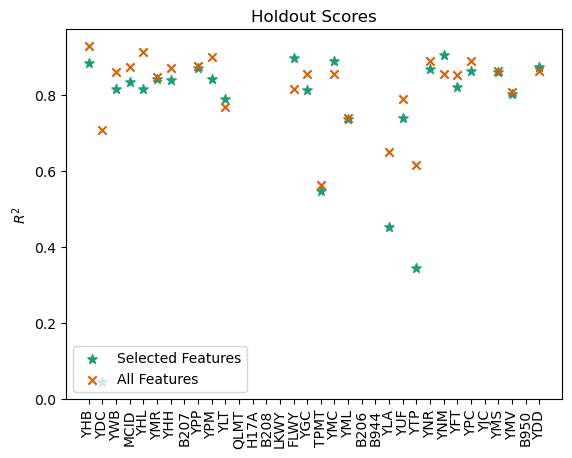

In [32]:
plotting.compare_score_different_feats_scatter(results_df, 
                               results_allfeats_df,
                               'Selected Features',
                               'All Features',
                               col_name='holdout_r2',
                               title='Holdout Scores'
                               )

In [33]:
# from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
# # Barchart of scores
# # Based off of 
# # https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
# width = 0.25  # the width of the bars
# multiplier = 0

# #colors = ['#1b9e77', '#d95f02', '#7570b3']
# #colors = ['#66c2a5', '#fc8d62', '#8da0cb']
# #colors = ['#a6cee3', '#1f78b4', '#b2df8a']
# colors = ['#edf8b1', '#7fcdbb', '#2c7fb8']

# df = results_df

# fig, ax = plt.subplots(layout='constrained', figsize=(5, 8))
# y =np.arange(results_df['station'].shape[0])

# for i, col in enumerate(['holdout_r2', 'test_r2', 'train_r2']):
#     offset = width * multiplier
#     rects = ax.barh(y + offset, results_df[col], width, label=col, color=colors[i])
#     #ax.bar_label(rects, padding=3)
#     multiplier += 1
    
# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_xlabel(f'$R^2$')
# ax.set_title('Selected Features')
# ax.set_yticks(y + width, results_df['station'])
# ax.set_yticklabels(results_df['station'])
# ax.legend(loc='upper left', ncols=3)
# ax.set_xlim([0, 1.0])
# ax.set_ylim([-0.5, np.max(y)+2.5])
# ax.xaxis.set_minor_locator(MultipleLocator(0.1))
# ax.grid(which='both', axis='x', zorder=0)
# plt.show()

In [34]:
# plotting.scores_heatmap(results_df.sort_values('station'),
#                         midpoint_normalize=True,
#                         midpoint=0.8,
#                         cmap_min=0,
#                         title='Selected Features',
#                         cbar_label=f'$R^2$'
#                         )

# plotting.scores_heatmap(results_allfeats_df.sort_values('station'),
#                         midpoint_normalize=True,
#                         midpoint=0.8,
#                         cmap_min=0,
#                         title='All Features',
#                         cbar_label=f'$R^2$'
#                         )

# Make tables/heatmaps to compare the scores

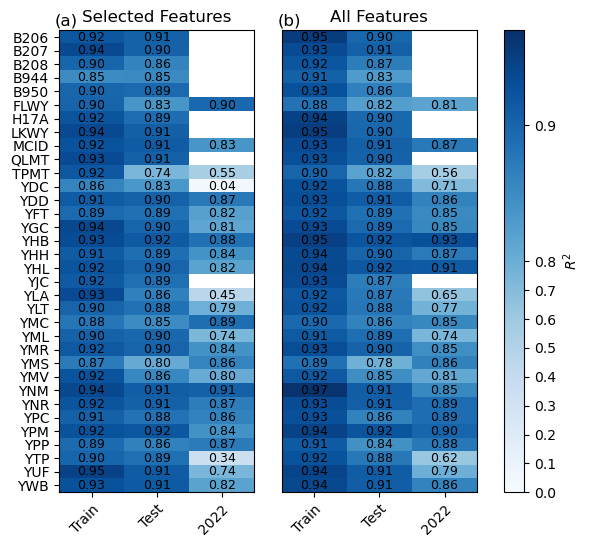

In [35]:
fig, axes = plt.subplots(1, 3, width_ratios=[2, 2, 0.2], figsize=(6, 6))

midpoint_normalize = True
midpoint = 0.8
cmap_min = 0
cmap_max = 0.97
xlabels=['Train', 'Test', '2022']

im1 = plotting.scores_heatmap(results_df.sort_values('station'),
                        midpoint_normalize=midpoint_normalize,
                        midpoint=midpoint,
                        cmap_min=cmap_min,
                        cmap_max=cmap_max,
                        title='Selected Features',
                        ax=axes[0],
                        show_ylabels=True,
                        show_cbar=False,
                        xticklabels=xlabels,
                        tablefontsize=9)
im2 = plotting.scores_heatmap(results_allfeats_df.sort_values('station'),
                        midpoint_normalize=midpoint_normalize,
                        midpoint=midpoint,
                        cmap_min=cmap_min,
                        cmap_max=cmap_max,
                        title='All Features',
                        ax=axes[1],
                        show_ylabels=False,
                        show_cbar=False,
                        xticklabels=xlabels,
                        tablefontsize=9)
plt.colorbar(im2, cax=axes[2], label=f'$R^2$', ticks=np.arange(0, 1.0, 0.1))
#fig.tight_layout()

sp_labels = ['(a)', '(b)']
for i, ax in enumerate(axes[:-1]):
    ax.text(-0.02, 
            1.01, 
            sp_labels[i], 
            transform=ax.transAxes,
            fontsize=12)
    
fig.show()

cmap min set to -0.6639999999999999


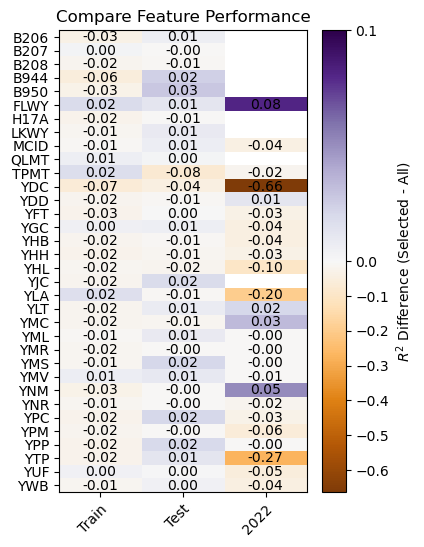

In [36]:
diff_df = results_df.sort_values('station')[['train_r2', 'test_r2', 'holdout_r2']] - results_allfeats_df.sort_values('station')[['train_r2', 'test_r2', 'holdout_r2']]
diff_df['station'] = results_df.sort_values('station')['station']

im = plotting.scores_heatmap(diff_df,
                        midpoint_normalize=True,
                        midpoint=0,
                        cmap_max = 0.1,
                        cmap_min = None,
                        title='Compare Feature Performance',
                        show_ylabels=True,
                        show_cbar=True,
                        xticklabels=xlabels,
                        cbar_label=f'$R^2$ Difference (Selected - All)',
                        cmap=cm.PuOr,
                        tablefontcolor='k',
                        tablefontsize=None,
                        tight_layout=True)


cmap midpoint set to 284.5
cmap min set to 0
cmap max set to 4009


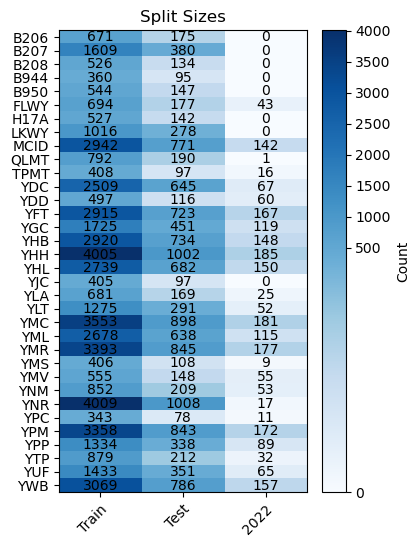

In [37]:
im = plotting.scores_heatmap(split_cnts.sort_values('station'),
                        cols=['cnt_train', 'cnt_test', 'cnt_holdout'],
                        midpoint_normalize=True,
                        midpoint=None,
                        title='Split Sizes',
                        show_ylabels=True,
                        show_cbar=True,
                        xticklabels=xlabels,
                        cbar_label=f'Count',
                        cmap=cm.Blues,
                        tablefontcolor='k',
                        tablefontsize=None,
                        tight_layout=True,
                        tablevalueprec=0)
                        


cmap min set to -0.6639999999999999
cmap midpoint set to 284.5
cmap min set to 0
cmap max set to 4009


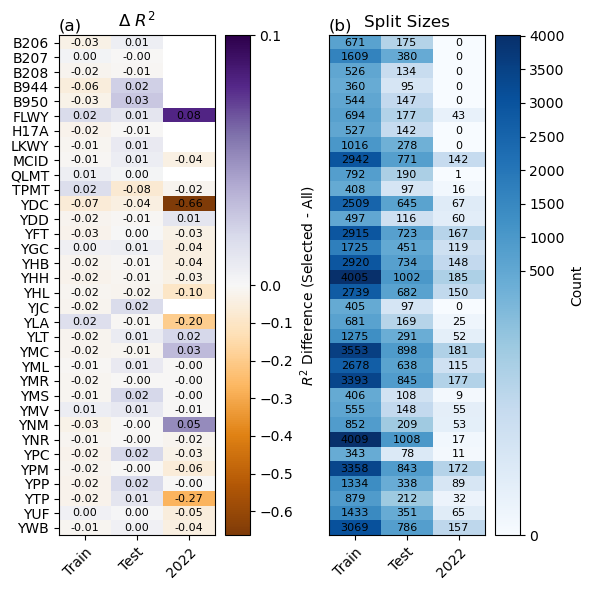

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(6, 6)) #, width_ratios=[2, 2, 0.2], figsize=(6, 6))

im1 = plotting.scores_heatmap(diff_df,
                             ax = axes[0],
                            midpoint_normalize=True,
                            midpoint=0,
                            cmap_max = 0.1,
                            cmap_min = None,
                            title='$\Delta$ $R^2$',
                            show_ylabels=True,
                            show_cbar=True,
                            xticklabels=xlabels,
                            cbar_label=f'$R^2$ Difference (Selected - All)',
                            cmap=cm.PuOr,
                            tablefontcolor='k',
                            tablefontsize=8,
                            tight_layout=True,
                            )

im2 = plotting.scores_heatmap(split_cnts.sort_values('station'),
                        ax=axes[1],
                        cols=['cnt_train', 'cnt_test', 'cnt_holdout'],
                        midpoint_normalize=True,
                        midpoint=None,
                        title='Split Sizes',
                        show_ylabels=False,
                        show_cbar=True,
                        xticklabels=xlabels,
                        cbar_label=f'Count',
                        cmap=cm.Blues,
                        tablefontcolor='k',
                        tablefontsize=8,
                        tight_layout=True,
                        tablevalueprec=0)

sp_labels = ['(a)', '(b)']
for i, ax in enumerate(axes):
    ax.text(0.00, 
            1.01, 
            sp_labels[i], 
            transform=ax.transAxes,
            fontsize=12)
    
fig.tight_layout()

cmap midpoint set to 284.5
cmap min set to 0
cmap max set to 4009
cmap min set to -0.6639999999999999


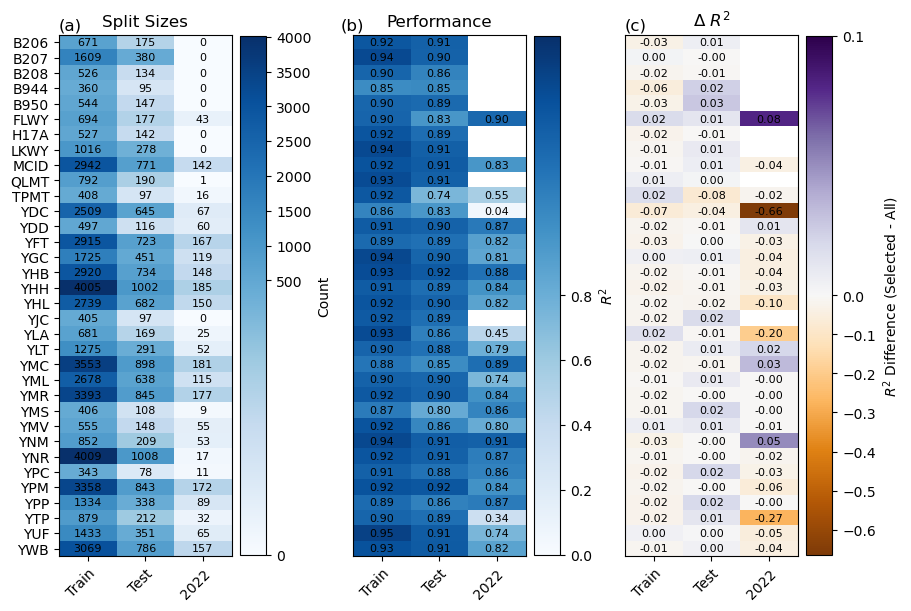

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(9, 6), constrained_layout=True) #, width_ratios=[2, 2, 0.2], figsize=(6, 6))


im1 = plotting.scores_heatmap(split_cnts.sort_values('station'),
                        ax=axes[0],
                        cols=['cnt_train', 'cnt_test', 'cnt_holdout'],
                        midpoint_normalize=True,
                        midpoint=None,
                        title='Split Sizes',
                        show_ylabels=True,
                        show_cbar=True,
                        xticklabels=xlabels,
                        cbar_label=f'Count',
                        cmap=cm.Blues,
                        tablefontcolor='k',
                        tablefontsize=8,
                        tight_layout=True,
                        tablevalueprec=0)

im2 = plotting.scores_heatmap(results_df.sort_values('station'),
                        midpoint_normalize=midpoint_normalize,
                        midpoint=midpoint,
                        cmap_min=cmap_min,
                        cmap_max=cmap_max,
                        title='Performance',
                        ax=axes[1],
                        show_ylabels=False,
                        show_cbar=True,
                        xticklabels=xlabels,
                        tablefontsize=8,
                        cbar_label=f'$R^2$')

im3 = plotting.scores_heatmap(diff_df,
                             ax = axes[2],
                            midpoint_normalize=True,
                            midpoint=0,
                            cmap_max = 0.1,
                            cmap_min = None,
                            title='$\Delta$ $R^2$',
                            show_ylabels=False,
                            show_cbar=True,
                            xticklabels=xlabels,
                            cbar_label=f'$R^2$ Difference (Selected - All)',
                            cmap=cm.PuOr,
                            tablefontcolor='k',
                            tablefontsize=8,
                            tight_layout=True,
                            )

sp_labels = ['(a)', '(b)', '(c)']
sp_label_x = [0,-0.07, 0]
for i, ax in enumerate(axes):
    ax.text(sp_label_x[i], 
            1.01, 
            sp_labels[i], 
            transform=ax.transAxes,
            fontsize=12)
    
#fig.tight_layout()

# Actual vs predicted plots

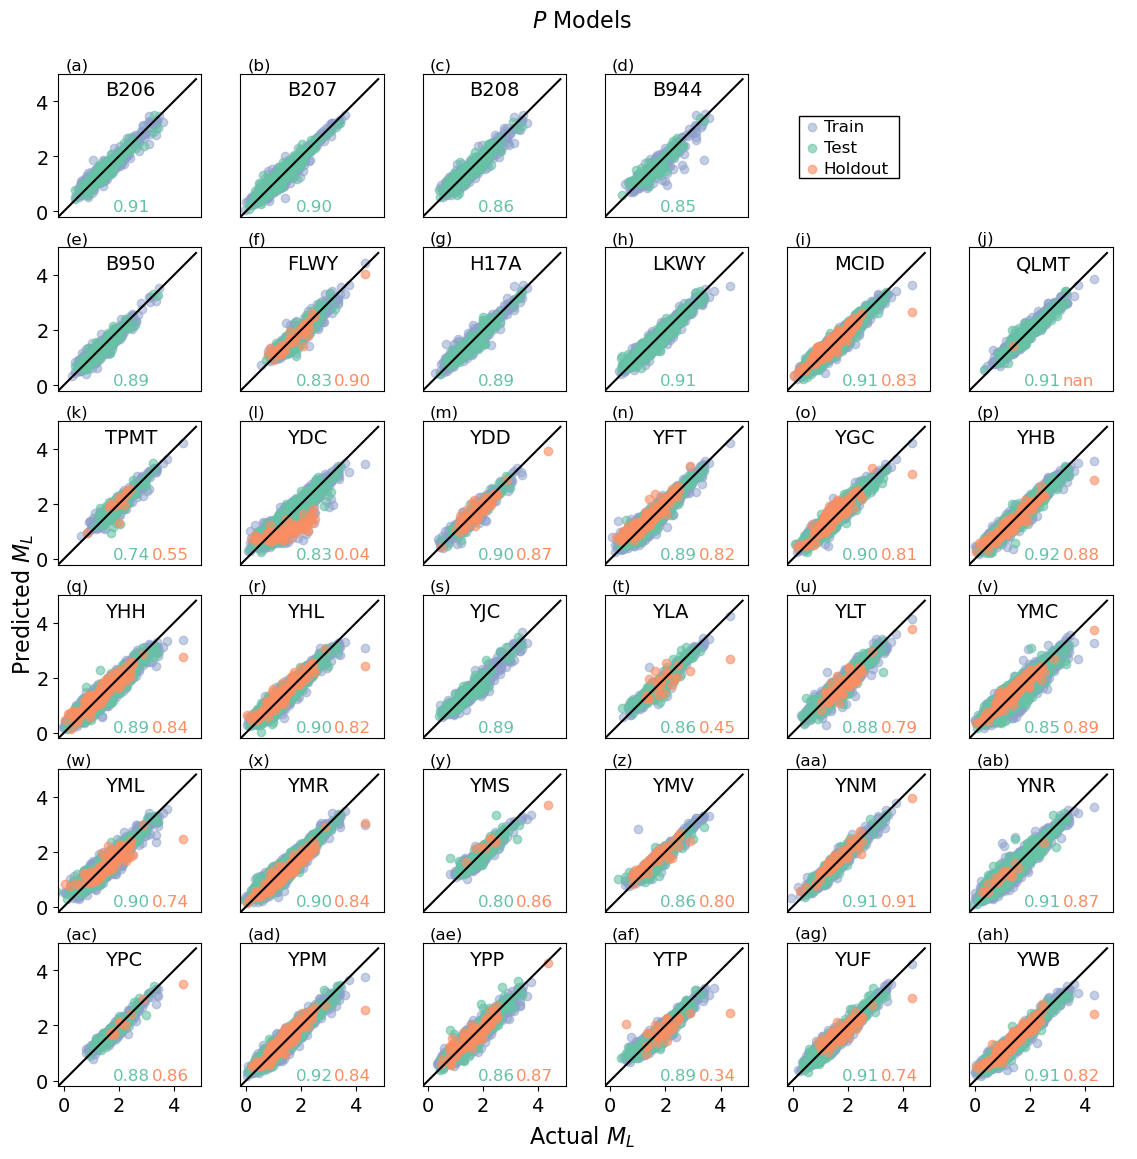

In [40]:
plotting.actual_v_predicted(results_df,
                     train_preds_df, 
                     test_preds_df,
                     holdout_preds_df,
                     inner_ticks_on=False,
                     title='$\it P$ Models',
                     colors=['#8da0cb', '#66c2a5', '#fc8d62'],
                     alphas=[0.5, 0.6, 0.6])

# Average the predictions

In [12]:
test_avg_df = compute_network_avg_prediction(test_preds_df)
holdout_avg_df = compute_network_avg_prediction(holdout_preds_df)

In [13]:
(test_avg_df['magnitude'] - test_avg_df['predicted_magnitude']).describe()

count    1283.000000
mean       -0.009790
std         0.123327
min        -0.660230
25%        -0.080923
50%        -0.005036
75%         0.065375
max         0.695516
dtype: float64

In [14]:
(holdout_avg_df['magnitude'] - holdout_avg_df['predicted_magnitude']).describe()

count    197.000000
mean      -0.033043
std        0.145111
min       -0.394100
25%       -0.108754
50%       -0.033286
75%        0.045763
max        1.171310
dtype: float64

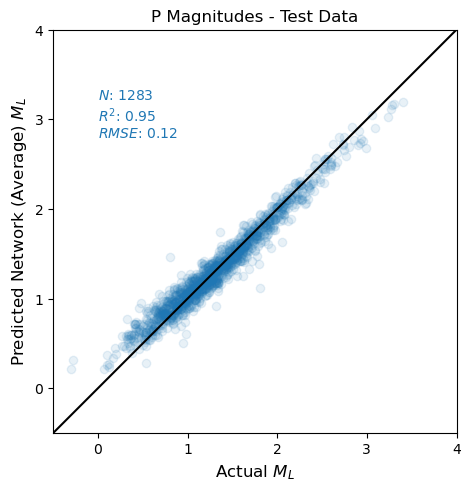

In [22]:
plotting.actual_v_network_avg_prediction([test_avg_df],
                                title='P Magnitudes - Test Data',
                                )

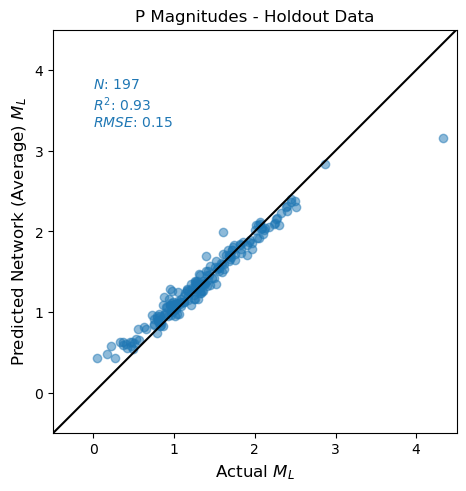

In [23]:
plotting.actual_v_network_avg_prediction([holdout_avg_df],
                                title='P Magnitudes - Holdout Data',
                                plot_lims=[-0.5, 4.5],
                                alphas=[0.5])

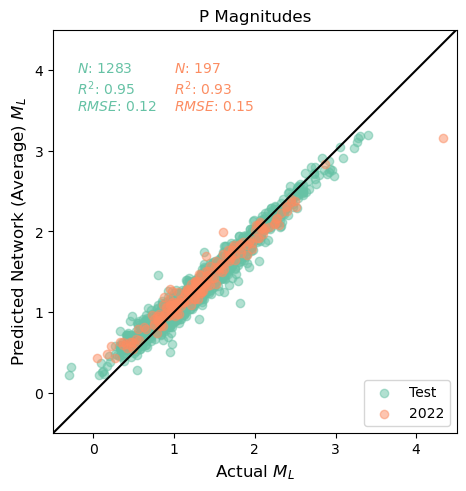

In [26]:
plotting.actual_v_network_avg_prediction([test_avg_df, holdout_avg_df],
                                    title='P Magnitudes',
                                    plot_lims=[-0.5, 4.5],
                                    alphas=[0.5, 0.5],
                                    legend_labels=['Test', '2022'],
                                    plot_legend=True,
                                    marker_colors=['#66c2a5', '#fc8d62'],
                                    text_x = [-0.2, 0.0],
                                    text_y=[-1.0, -1.0])

In [34]:
r2_score(holdout_avg_df[holdout_avg_df['magnitude'] < 4]['magnitude'],
         holdout_avg_df[holdout_avg_df['magnitude'] < 4]['predicted_magnitude'])

0.9473466101208783

In [35]:
mean_squared_error(holdout_avg_df[holdout_avg_df['magnitude'] < 4]['magnitude'],
         holdout_avg_df[holdout_avg_df['magnitude'] < 4]['predicted_magnitude'],
         squared=False)

0.12310518821250238

In [27]:
train_preds_df.iloc[train_preds_df['magnitude'].argmax()]

Evid                   60203137
magnitude              4.326333
predicted_magnitude    3.569156
station                     YHB
Name: 1442, dtype: object

In [28]:
holdout_preds_df.iloc[holdout_preds_df['magnitude'].argmax()]

Evid                   60497322
magnitude              4.332082
predicted_magnitude    3.702084
station                     YMS
Name: 8, dtype: object

In [29]:
test_preds_df.iloc[test_preds_df['magnitude'].argmax()]

Evid                   60071847
magnitude               3.40459
predicted_magnitude    3.091083
station                     YHB
Name: 235, dtype: object

# Look at residuals

(-1.1, 1.1)

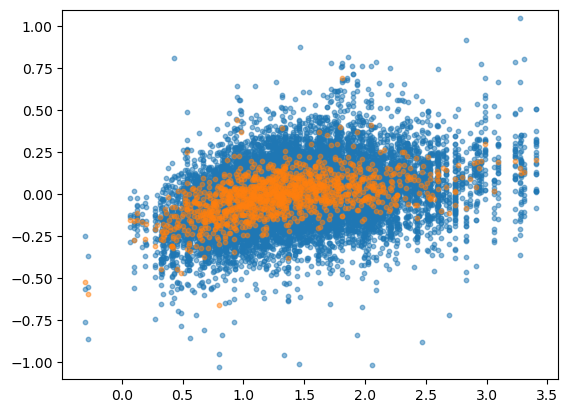

In [43]:
plt.scatter(test_preds_df['magnitude'], 
            test_preds_df['magnitude'] - test_preds_df['predicted_magnitude'],
            alpha=0.5,
            s=10)
plt.scatter(test_avg_df['magnitude'], 
            test_avg_df['magnitude'] - test_avg_df['predicted_magnitude'],
            alpha=0.5,
            s=10)
plt.ylim([-1.1, 1.1])

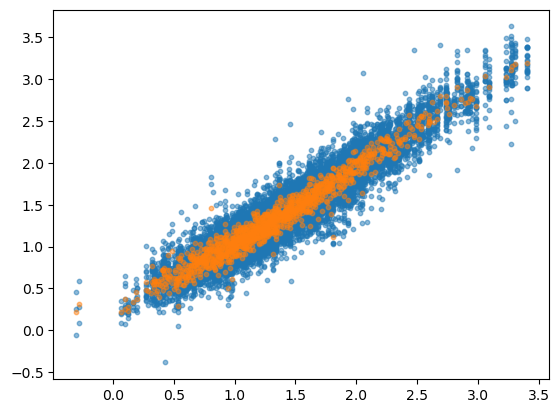

In [44]:
plt.scatter(test_preds_df['magnitude'], 
            test_preds_df['predicted_magnitude'],
            alpha=0.5,
            s=10)
plt.scatter(test_avg_df['magnitude'], 
            test_avg_df['predicted_magnitude'],
            alpha=0.5,
            s=10)

# Average predictions when using all features

In [36]:
diff_df['train_r2'].describe()[['50%', 'std']]

50%   -0.016000
std    0.017859
Name: train_r2, dtype: float64

In [37]:
diff_df['test_r2'].describe()[['50%', 'std']]

50%    0.001500
std    0.019243
Name: test_r2, dtype: float64

In [38]:
diff_df['holdout_r2'].describe()[['50%', 'std']]

50%   -0.028000
std    0.145138
Name: holdout_r2, dtype: float64

In [76]:
diff_df[diff_df['station'] != 'YDC']['holdout_r2'].describe()[['50%', 'std']]

50%   -0.0240
std    0.0733
Name: holdout_r2, dtype: float64

In [26]:
results_allfeats_df['train_r2'].describe()[['min', 'max', '50%']]

min    0.883
max    0.966
50%    0.929
Name: train_r2, dtype: float64

In [27]:
results_allfeats_df['test_r2'].describe()[['min', 'max', '50%']]

min    0.783
max    0.922
50%    0.891
Name: test_r2, dtype: float64

In [28]:
results_allfeats_df['holdout_r2'].describe()[['min', 'max', '50%']]

min    0.564
max    0.928
50%    0.855
Name: holdout_r2, dtype: float64

In [15]:
all_stats = results_df['station']
pred_path = os.path.join(datadir,'p_models', 'all_features')
train_preds_allfeat_df = combine_prediction_files(all_stats, pred_path,'P', 'train')
test_preds_allfeat_df = combine_prediction_files(all_stats, pred_path,'P', 'test')
holdout_preds_allfeat_df = combine_prediction_files(df_2022['station'].unique(), pred_path,'P', 'holdout')


In [17]:
(test_preds_allfeat_df['magnitude'] - test_preds_allfeat_df['predicted_magnitude']).describe()[['50%', 'std']]

50%   -0.000404
std    0.180181
dtype: float64

In [18]:
(holdout_preds_allfeat_df['magnitude'] - holdout_preds_allfeat_df['predicted_magnitude']).describe()[['50%', 'std']]

50%   -0.029485
std    0.220845
dtype: float64

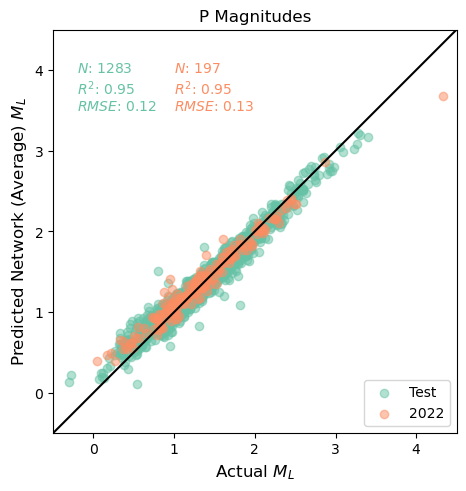

In [20]:
test_avg_allfeat_df = compute_network_avg_prediction(test_preds_allfeat_df)
holdout_avg_allfeat_df = compute_network_avg_prediction(holdout_preds_allfeat_df)
plotting.actual_v_network_avg_prediction([test_avg_allfeat_df, holdout_avg_allfeat_df],
                                    title='P Magnitudes',
                                    plot_lims=[-0.5, 4.5],
                                    alphas=[0.5, 0.5],
                                    legend_labels=['Test', '2022'],
                                    plot_legend=True,
                                    marker_colors=['#66c2a5', '#fc8d62'],
                                    text_x = [-0.2, 0.0],
                                    text_y=[-1.0, -1.0])

In [21]:
(test_avg_allfeat_df['magnitude'] - test_avg_allfeat_df['predicted_magnitude']).describe()[['50%', 'std']]

50%   -0.002912
std    0.119920
dtype: float64

In [22]:
(holdout_avg_allfeat_df['magnitude'] - holdout_avg_allfeat_df['predicted_magnitude']).describe()[['50%', 'std']]

50%   -0.024884
std    0.124240
dtype: float64

In [75]:
results_allfeats_df[results_allfeats_df['station'] == 'YDC']

,cv_mean_best,cv_std_best,cv_ind_sel,cv_mean_sel,cv_std_sel,C_best,gamma_best,C_sel,gamma_sel,train_r2,train_rmse,test_r2,test_rmse,holdout_r2,holdout_rmse,station,phase
1,0.877887,0.011082,30,0.877887,0.011082,10.0,0.01,10.0,0.01,0.924,0.155,0.877,0.189,0.708,0.319,YDC,P
